In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

KeyboardInterrupt: 

# 1. Loading the dataset

In [ ]:
# Define the labels
labels = ['PNEUMONIA', 'NORMAL', 'TUBERCULOSIS', 'COVID19']

# Set the image size
img_size = 150

# Function to load the training, test, and validation data
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [ ]:
# Load the data

train = get_training_data('C:\\Users\\ACER\\Desktop\\Jupyter\\Project v2 (PNCT)\\v2 Dataset 4 (Covid Fixed, Normal as in Dataset 1)\\train')
test = get_training_data('C:\\Users\\ACER\\Desktop\\Jupyter\\Project v2 (PNCT)\\v2 Dataset 4 (Covid Fixed, Normal as in Dataset 1)\\test')
val = get_training_data('C:\\Users\\ACER\\Desktop\\Jupyter\\Project v2 (PNCT)\\v2 Dataset 4 (Covid Fixed, Normal as in Dataset 1)\\val')

# 2. Data Exploration

In [ ]:
print(train[300])
train.shape

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    elif(i[1] == 1):
        l.append("Normal")
    elif(i[1] == 2):
        l.append("Tuberculosis")
    elif(i[1] == 3):
        l.append("Covid19")
print(l)      

In [ ]:
sns.set_style('darkgrid')
sns.countplot(x=l)

In [ ]:
# ATTENTION Required here

# Previewing an image from each class

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[600][0], cmap='gray')
plt.title(labels[train[600][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[1200][0], cmap='gray')
plt.title(labels[train[1200][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
# Split the data into features and labels

x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# Accessing the no. of elements of each class in train, test, and val respectively

from collections import Counter

def get_element_frequency(arr):
    frequency_counter = Counter(arr)
    return frequency_counter

for i in (y_train,y_test,y_val):
    frequency = get_element_frequency(i)
    for element, count in frequency.items():
        print(f"The element {element} appears {count} times.")
    print()

In [ ]:
num_test_samples = len(x_train)
print("Number of x_train samples:", num_test_samples)

num_test_samples = len(x_test)
print("Number of x_test samples:", num_test_samples)

num_test_samples = len(x_val)
print("Number of x_val samples:", num_test_samples)

# 3. Data Preprocessing

**Normalization:** We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# Resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

**Data Augmentation:** In order to avoid overfitting problem, we need to expand artificially our dataset. We can make the existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

# 4. Model Training

In [ ]:
# Building the model

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # Adjust the number of classes here
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
len(model.layers)

In [ ]:
# Model Architecture Visualization

from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [ ]:
# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [ ]:
y_train.size

In [ ]:
print(y_train[500], y_train[1000], y_train[1500], y_train[2000])

In [ ]:
# Training the model
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), callbacks=[learning_rate_reduction])

In [ ]:
#from tensorflow.keras.models import load_model

#model = load_model(' ')

In [ ]:
print("Loss of the model is - ", model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", model.evaluate(x_test, y_test)[1] * 100, "%")

In [ ]:
print("Loss of the model is - ", model.evaluate(x_train, y_train)[0])
print("Accuracy of the model is - ", model.evaluate(x_train, y_train)[1] * 100, "%")

In [ ]:
print("Loss of the model is - ", model.evaluate(x_val, y_val)[0])
print("Accuracy of the model is - ", model.evaluate(x_val, y_val)[1] * 100, "%")

In [32]:
model.save("Jv2.7 [81.61% acc] Dataset 1, 20 epoch.h5")

# 5. Post-Training Analysis:

In [28]:
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)  # Convert predictions to class labels
true_labels = np.argmax(y_test, axis=1)  # Convert true labels to class labels

17/17 [==============================] - 6s 224ms/step


In [29]:
print(classification_report(true_labels, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

   PNEUMONIA       0.74      0.96      0.84       140
      NORMAL       0.92      0.41      0.57       140
TUBERCULOSIS       0.96      0.99      0.98       139
     COVID19       0.73      0.93      0.82       114

    accuracy                           0.82       533
   macro avg       0.84      0.82      0.80       533
weighted avg       0.84      0.82      0.80       533



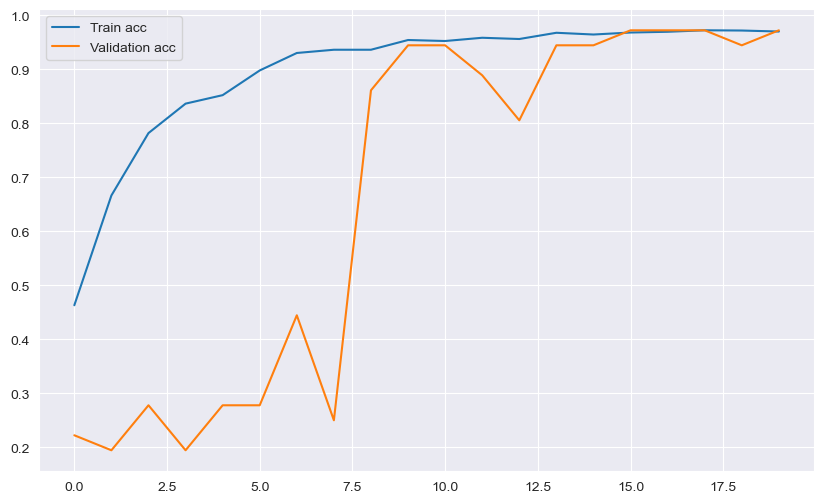

In [30]:
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

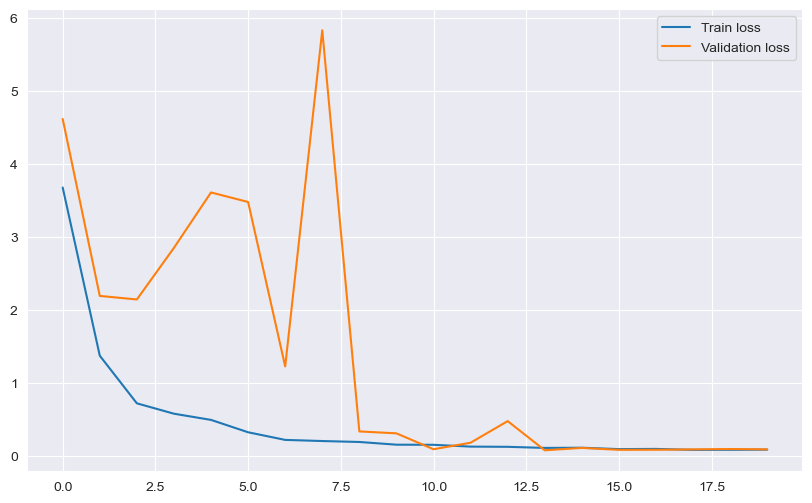

In [31]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

# 6. Confusion Matrix

In [32]:
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[135,   4,   0,   1],
       [ 46,  58,   0,  36],
       [  0,   0, 137,   2],
       [  2,   1,   5, 106]], dtype=int64)

In [33]:
cm = pd.DataFrame(cm, index=labels, columns=labels)

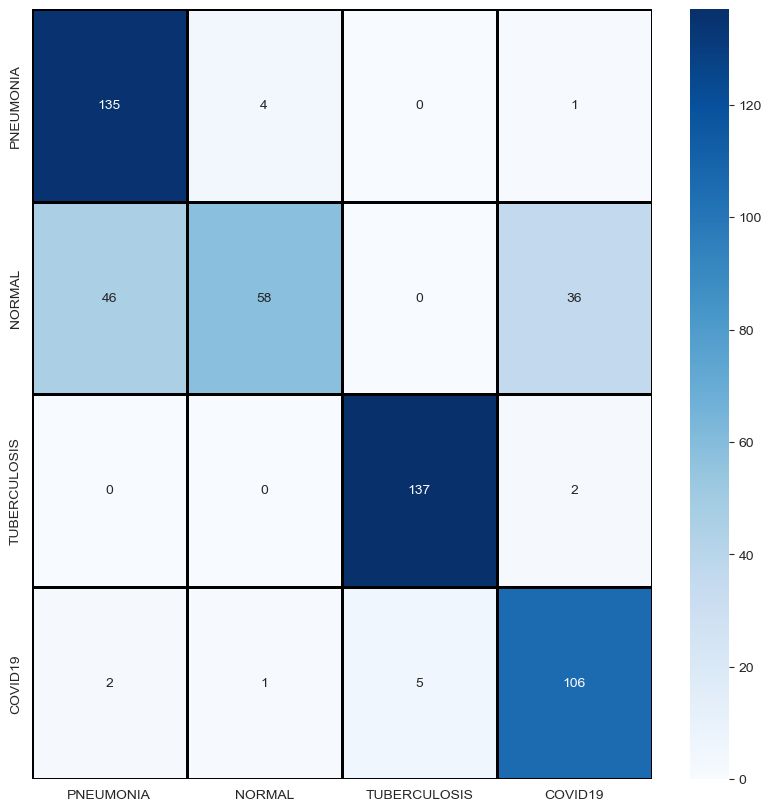

In [34]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels)
plt.show()

# 7. Visualizing the predicted images

In [29]:
correct = np.nonzero(predicted_labels == true_labels)[0]
incorrect = np.nonzero(predicted_labels != true_labels)[0]

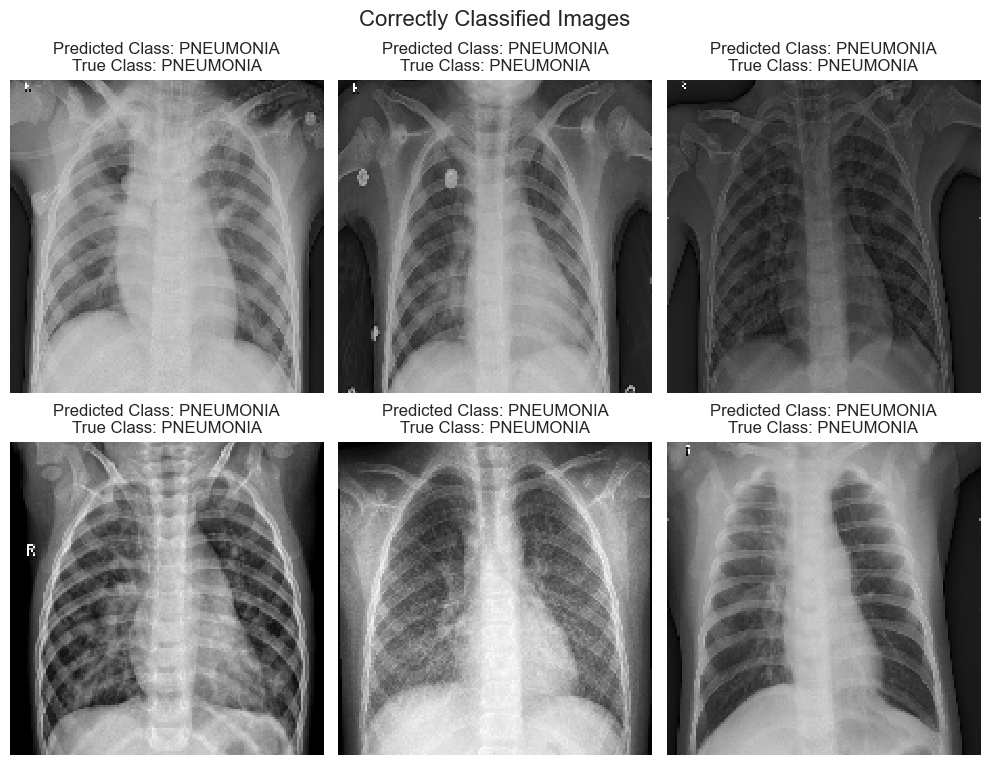

In [30]:
# Visualize correctly classified images

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Correctly Classified Images', fontsize=16)
for i, idx in enumerate(correct[:6]):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(x_test[idx].reshape(img_size, img_size), cmap="gray", interpolation='none')
    axes[row, col].set_title("Predicted Class: {}\nTrue Class: {}".format(labels[predicted_labels[idx]], labels[true_labels[idx]]))
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

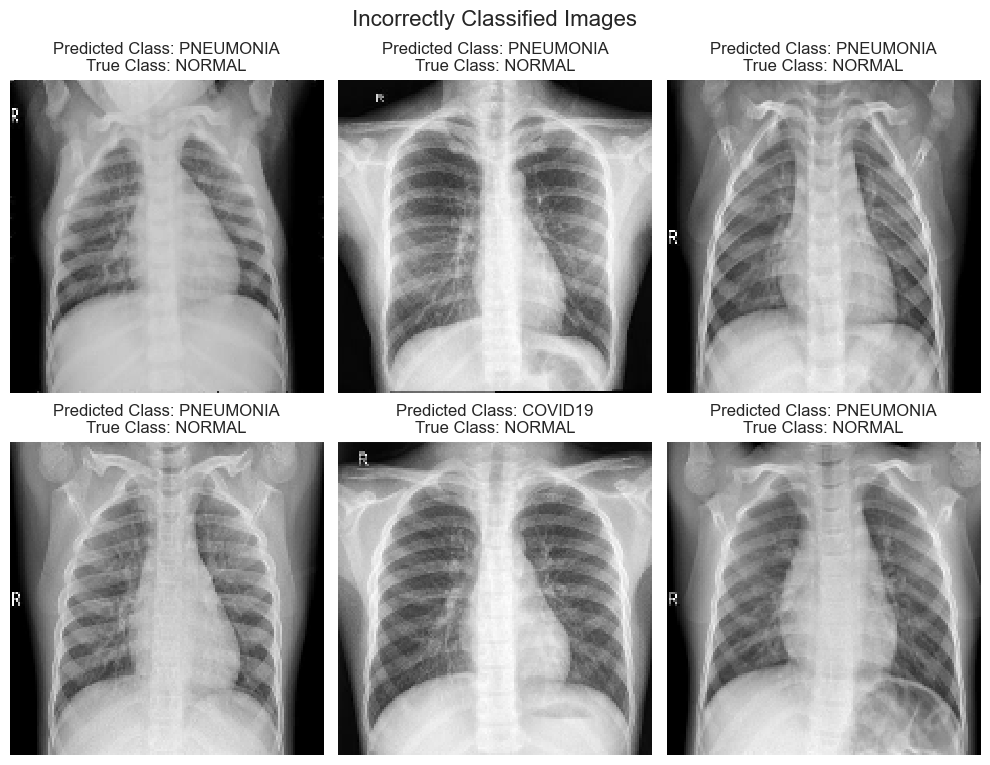

In [31]:
# Visualize incorrectly classified images

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Incorrectly Classified Images', fontsize=16)
for i, idx in enumerate(incorrect[:6]):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(x_test[idx].reshape(img_size, img_size), cmap="gray", interpolation='none')
    axes[row, col].set_title("Predicted Class: {}\nTrue Class: {}".format(labels[predicted_labels[idx]], labels[true_labels[idx]]))
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

# 8. Random Predictions

In [32]:
image = "C:\\Users\ACER\\Desktop\\Jupyter\\Jv2 Dataset\\test\\COVID19\\COVID19(22).jpg"
def preprocess_image(image_path):
    img_arr = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_arr = cv2.resize(img_arr, (img_size, img_size))
    preprocessed_img = np.array(resized_arr) / 255.0
    preprocessed_img = preprocessed_img.reshape(-1, img_size, img_size, 1)
    return preprocessed_img

# Assuming 'image' is the variable containing the path to the image you want to predict
preprocessed_img = preprocess_image(image)
prediction = model.predict(preprocessed_img)
predicted_class = labels[int(np.round(prediction))]
print("Predicted class:", predicted_class)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
